In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks

# Hjælpefunktioner

In [274]:
def error_on_the_mean(data, n):
    """
    Returnerer gennemsnit og usikkerhed på gennemsnittet for et datasæt.
    """
    return (np.mean(data), np.std(data) / np.sqrt(n))

In [275]:
def voltage_to_current(V, R_LB, R_HH, sigma_V, sigma_R_HH):
    """
    Returnerer strømmen I givet spænding V og modstande R_LB og R_HH jvf. PreLab 1.
    """
    return V / np.sqrt(R_LB**2 + R_HH**2)

In [276]:
def current_error(V, R_LB, R_HH, sigma_V, sigma_R_HH):
    """
    Returnerer usikkerhed på strømmen jvf. ophobningsloven.
    """
    return np.sqrt( (sigma_V**2)/(R_LB**2 + R_HH**2) + (V * R_HH * sigma_R_HH)**2/(R_LB**2 + R_HH**2)**3 )

In [277]:
def current_to_magnetic_field(I, mu_0, n, d):
    """
    Returnerer stykren af det magnetiske felt i HH-spolen
    """
    return (n * mu_0 * I) /(np.sqrt(2) * d)


In [278]:
def magnetic_field_error(I, mu_0, n, d, sigma_I, sigma_d, sigma_n):
    """
    Returnerer usikkerhed på styrken af det magnetiske felt i HH-spolen (fundet med ophobningsloven)
    """
    return (1/2) * np.sqrt((2 * n**2 * mu_0**2 * sigma_I**2)/(d**2) + (2 * mu_0**2 * I**2 * sigma_n**2)/(d**2) + (2 * n**2 * mu_0**2 * I**2 * sigma_d**2)/(d**4))


# Indlæsning af data

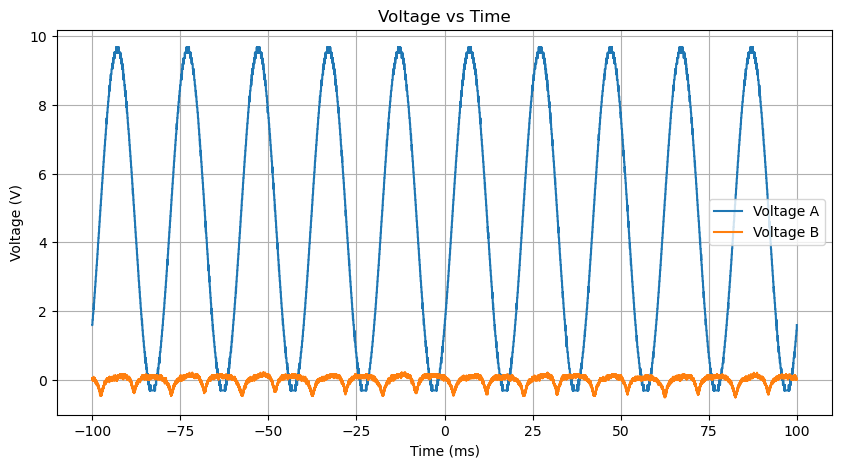

In [279]:
# Alle filer ligger i mappen "CSV_data". Filnavnene er i formatet xx MHz.csv, hvor xx er frekvensen i MHz.

# Data er i formatet Tid (ms), Spænding kanal A (V), Spænding kanal B (V).

test_file_name = "CSV_data/15.7 MHz.csv"

# Indlæs data fra CSV-fil
data = pd.read_csv(test_file_name, header=[0,1])
time_arr = data.iloc[:, 0].to_numpy()
voltage_arr_A = data.iloc[:, 1].to_numpy()
voltage_arr_B = data.iloc[:, 2].to_numpy()

# Plot data
plt.figure(figsize=(10, 5))
plt.plot(time_arr, voltage_arr_A, label='Voltage A')
plt.plot(time_arr, voltage_arr_B, label='Voltage B')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time')
plt.legend()
plt.grid()
plt.show()





# Detektering af peaks

Afstand mellem peaks: [3631 4110 3657 4232 3667 4066 3715 4105 3785 4080 3656 4086 3702 4111
 3782 4124 3694 4123 3611]
Antal peaks i kanal B: 20


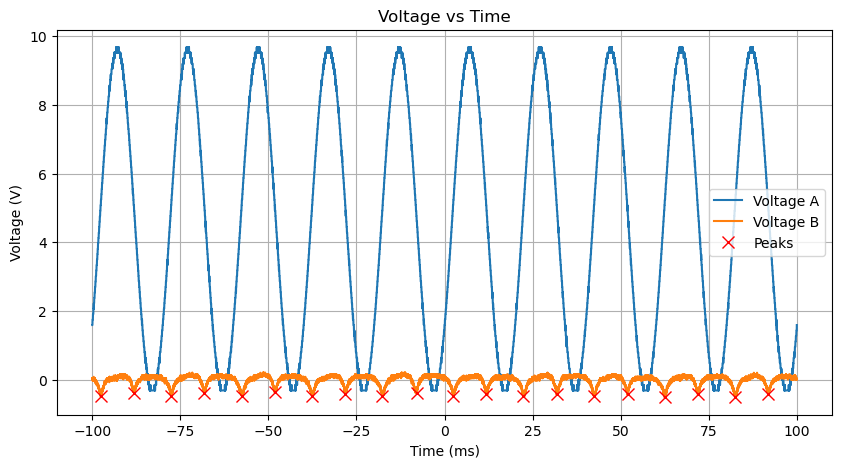

In [280]:
# Find peaks i kanal B data
peaks_B, _ = find_peaks(-voltage_arr_B, height=0.1, prominence=0.4, distance=200)

# Debug: Tjek afstande mellem peaks
peak_distances = np.diff(peaks_B)
print("Afstand mellem peaks:", peak_distances)

print("Antal peaks i kanal B:", len(peaks_B))

# Plot data med peaks
plt.figure(figsize=(10, 5))
plt.plot(time_arr, voltage_arr_A, label='Voltage A')
plt.plot(time_arr, voltage_arr_B, label='Voltage B')
plt.plot(time_arr[peaks_B], voltage_arr_B[peaks_B], "x", label='Peaks', color='red', markersize=8)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time')
plt.legend()
plt.grid()
plt.show()

# Faktisk detektering af peaks

In [281]:
def analyze_csv(file_location, height=0.1, prominence=0.4, distance=200):
    """
    Analyserer en CSV-fil og finder peaks i kanal B data

    Input:
        file_location (str): Filstien til CSV-filen.
        height (float): Minimumshøjde af peaks (svarer til hvor langt under 0 V peaksne mindst skal være).
        prominence (float): Styrer hvor 'fremtrædende' peaks skal være for at blive detekteret.
        distance (int): Minimum afstand (i indeks!). Dvs. antal målinger mellem peaks.

    Output:
        dict: Et dictionary der indeholder arrays med rådata, placeringen af peaksne og værdien af kanal A ved peaksne (time_arr, voltage_arr_A, voltage_arr_B, peaks, voltage_A_at_peaks).
    """
    # Load data from CSV file
    data = pd.read_csv(file_location, header=[0, 1])
    time_arr = data.iloc[:, 0].to_numpy()
    voltage_arr_A = data.iloc[:, 1].to_numpy()
    voltage_arr_B = data.iloc[:, 2].to_numpy()

    # Find peaks i kanal B data
    peaks, _ = find_peaks(-voltage_arr_B, height=height, prominence=prominence, distance=distance)

    # Debug: Print antal peaks fundet
    print(f"Fandt {len(peaks)} peaks i '{file_location}'")

    # # Plot data med peaks
    # plt.figure(figsize=(10, 5))
    # plt.plot(time_arr, voltage_arr_A, label='Voltage A')
    # plt.plot(time_arr, voltage_arr_B, label='Voltage B')
    # plt.plot(time_arr[peaks], voltage_arr_B[peaks], "x", label='Peaks', color='red', markersize=8)
    # plt.xlabel('Time (ms)')
    # plt.ylabel('Voltage (V)')
    # plt.title('Voltage vs Time')
    # plt.legend()
    # plt.grid()
    # plt.show()

    # Returner data og peaks, samt kanal A værdier ved peaks
    return {
        "time": time_arr,
        "voltage_A": voltage_arr_A,
        "voltage_B": voltage_arr_B,
        "peaks": peaks,
        "voltage_A_at_peaks": voltage_arr_A[peaks]
    }

# Eksempel
file_location = "CSV_data/15.7 MHz.csv"
result = analyze_csv(file_location)

Fandt 20 peaks i 'CSV_data/15.7 MHz.csv'


Fandt 20 peaks i 'CSV_data/14.9 MHz.csv'
Fandt 20 peaks i 'CSV_data/15.3 MHz.csv'
Fandt 20 peaks i 'CSV_data/15.7 MHz.csv'
Fandt 20 peaks i 'CSV_data/16.1 MHz.csv'
Fandt 20 peaks i 'CSV_data/16.3 MHz.csv'
Fandt 20 peaks i 'CSV_data/16.8 MHz.csv'
Fandt 20 peaks i 'CSV_data/17.8 MHz.csv'
Fandt 20 peaks i 'CSV_data/18.5 MHz.csv'
Fandt 21 peaks i 'CSV_data/19.3 MHz.csv'
Fandt 20 peaks i 'CSV_data/20.1 MHz.csv'
Fandt 21 peaks i 'CSV_data/21.2 MHz.csv'
Fandt 21 peaks i 'CSV_data/21.3 MHz.csv'
Fandt 20 peaks i 'CSV_data/21.7 MHz.csv'
Fandt 18 peaks i 'CSV_data/22.6 MHz.csv'
Fandt 18 peaks i 'CSV_data/23.1 MHz.csv'
Fandt 16 peaks i 'CSV_data/23.5 MHz.csv'
Fandt 12 peaks i 'CSV_data/24.1 MHz.csv'
Fandt 11 peaks i 'CSV_data/25.3 MHz.csv'
Fandt 11 peaks i 'CSV_data/25.4 MHz.csv'
Fandt 10 peaks i 'CSV_data/25.9 MHz.csv'
Fandt 10 peaks i 'CSV_data/26.2 MHz.csv'
Fandt 12 peaks i 'CSV_data/26.7 MHz.csv'


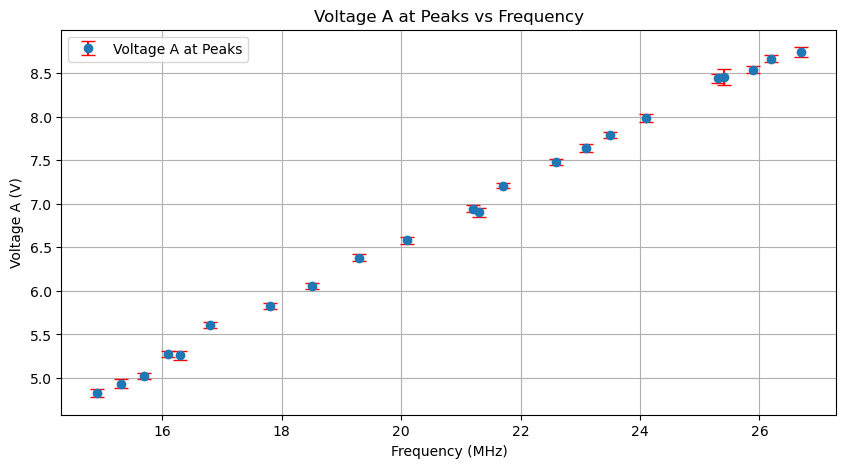

In [282]:
# Indeholder alle frekvenserne vi har målt ved i MHz
frequency_list = [14.9, 15.3, 15.7, 16.1, 16.3, 16.8, 17.8, 18.5, 19.3, 20.1, 21.2, 21.3, 21.7, 22.6, 23.1, 23.5, 24.1, 25.3, 25.4, 25.9, 26.2, 26.7]

# En liste med alle filnavne i formatet xx MHz.csv
file_list = [f"CSV_data/{str(freq)} MHz.csv" for freq in frequency_list]

voltage_A_averages = []
voltage_A_errors = []

for file_location in file_list:
    # Analyser CSV-filen og gem resultaterne
    result = analyze_csv(file_location)
    
    # Beregn gennemsnit og usikkerhed for kanal A ved peaks
    voltage_A_mean, voltage_A_error = error_on_the_mean(result["voltage_A_at_peaks"], len(result["peaks"]))
    
    # Gem resultaterne
    voltage_A_averages.append(voltage_A_mean)
    voltage_A_errors.append(voltage_A_error)

# Konverter til numpy arrays for nemmere håndtering
voltage_A_averages = np.array(voltage_A_averages)
voltage_A_errors = np.array(voltage_A_errors)

# Plot resultaterne
plt.figure(figsize=(10, 5))
plt.errorbar(frequency_list, voltage_A_averages, yerr=voltage_A_errors, fmt='o', label='Voltage A at Peaks', ecolor='red', capsize=5)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Voltage A (V)')
plt.title('Voltage A at Peaks vs Frequency')
plt.legend()
plt.grid()
plt.show()


    


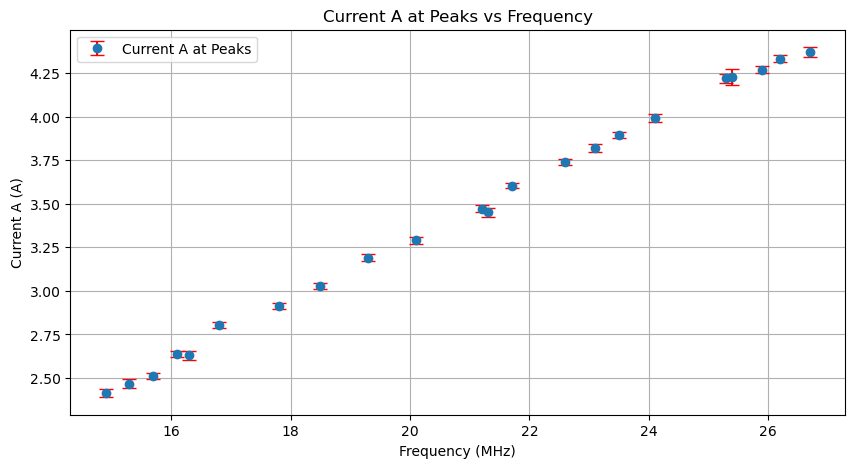

In [283]:
# Omregning til strøm
current_A_averages = []
current_A_errors = []

R_LB = 0  # ohm
R_HH = 2  # ohm

sigma_R_HH = 0.001  # usikkerhed på modstand

for i in range(len(voltage_A_averages)):
    V = voltage_A_averages[i]
    sigma_V = voltage_A_errors[i]
    I = voltage_to_current(V, R_LB=R_LB, R_HH=R_HH, sigma_V=sigma_V, sigma_R_HH=sigma_R_HH)
    I_error = current_error(V, R_LB=R_LB, R_HH=R_HH, sigma_V=sigma_V, sigma_R_HH=sigma_R_HH)
    current_A_averages.append(I)
    current_A_errors.append(I_error)

# Konverter til numpy arrays for nemmere håndtering
current_A_averages = np.array(current_A_averages)
current_A_errors = np.array(current_A_errors)

# Plot resultaterne
plt.figure(figsize=(10, 5))
plt.errorbar(frequency_list, current_A_averages, yerr=current_A_errors, fmt='o', label='Current A at Peaks', ecolor='red', capsize=5)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Current A (A)')
plt.title('Current A at Peaks vs Frequency')
plt.legend()
plt.grid()
plt.show()



I: 2.412488175 sigma_I: 0.022753815491368113 n: 122 d: 0.3 sigma_n: 2 sigma_d: 0.01
B: 0.0008717376969698859 B_error: 3.340942715535084e-05


I: 2.468031825 sigma_I: 0.025059645416364105 n: 122 d: 0.3 sigma_n: 2 sigma_d: 0.01
B: 0.000891808051732268 B_error: 3.4342758286925354e-05


I: 2.5116732250000005 sigma_I: 0.019697742066678348 n: 122 d: 0.3 sigma_n: 2 sigma_d: 0.01
B: 0.0009075776019927752 B_error: 3.445641445200561e-05


I: 2.6386302 sigma_I: 0.017680847513795485 n: 122 d: 0.3 sigma_n: 2 sigma_d: 0.01
B: 0.0009534527205312372 B_error: 3.5988973866126124e-05


I: 2.63071065 sigma_I: 0.025919613506930048 n: 122 d: 0.3 sigma_n: 2 sigma_d: 0.01
B: 0.0009505910400680625 B_error: 3.65320416798244e-05


I: 2.80539875 sigma_I: 0.01717272585117897 n: 122 d: 0.3 sigma_n: 2 sigma_d: 0.01
B: 0.0010137135057282495 B_error: 3.816367550654474e-05


I: 2.9126713250000007 sigma_I: 0.01875852391533547 n: 122 d: 0.3 sigma_n: 2 sigma_d: 0.01
B: 0.0010524757879427644 B_error: 3.967894779179462e-05


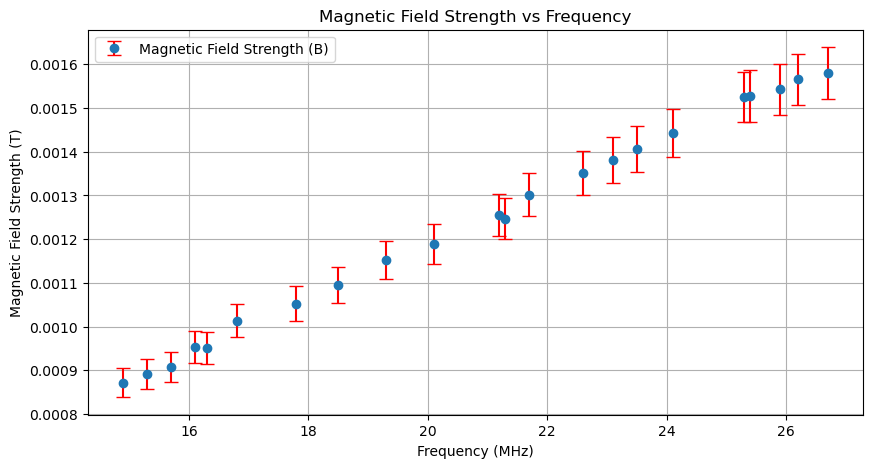

In [ ]:
# Omregning til magnetfeltsstyrke af magnetfeltet fra HH-spolen
HH_B_averages = []
HH_B_errors = []

mu_0 = 1.2566 * 10 **(-6) # N/A^2

n = 122 # antal vindinger spoler i HH-spolerne
d = 0.3 # diameter af HH-spolen i m

sigma_n = 2
sigma_d = 0.01 # usikkerhed på diameteren af HH-spolen i m

for i in range(len(current_A_averages)):
    I = current_A_averages[i]
    sigma_I = current_A_errors[i]
    B = current_to_magnetic_field(I=I, mu_0=mu_0, n=n, d=d)
    B_error = magnetic_field_error(I=I, mu_0=mu_0, n=n, d=d, sigma_I=sigma_I, sigma_d=sigma_d, sigma_n=sigma_n)
    HH_B_averages.append(B)
    HH_B_errors.append(B_error)

# Konverter til numpy arrays for nemmere håndtering
HH_B_averages = np.array(HH_B_averages)
HH_B_errors = np.array(HH_B_errors)

# Plotting af resultaterne
plt.figure(figsize=(10, 5))
plt.errorbar(frequency_list, HH_B_averages, yerr=HH_B_errors, fmt='o', label='Magnetic Field Strength (B)', capsize=5, ecolor='red')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Magnetic Field Strength (T)')
plt.title('Magnetic Field Strength vs Frequency')
plt.grid()
plt.legend()
plt.show()
